In [1]:
#Libraries to import.
%pylab inline
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)


from patch_fn import return_valid_and_random_pts, register
from patch_fn import make_figure, drift_corr, collate_data,calculate_measurements
import find_maxima_fn as maxima

import scipy
from os import listdir
from os.path import isfile, join
from scipy import signal
from scipy.ndimage import interpolation
import copy
from scipy.ndimage import filters
from scipy import ndimage

import csv
import numpy as np
import tifffile
import json
from sklearn.preprocessing import scale
import cPickle as pickle


Populating the interactive namespace from numpy and matplotlib


processing 170712 1.A S2.msr
processing 170712 1.C S4.msr
processing 170712 3.D S1.msr


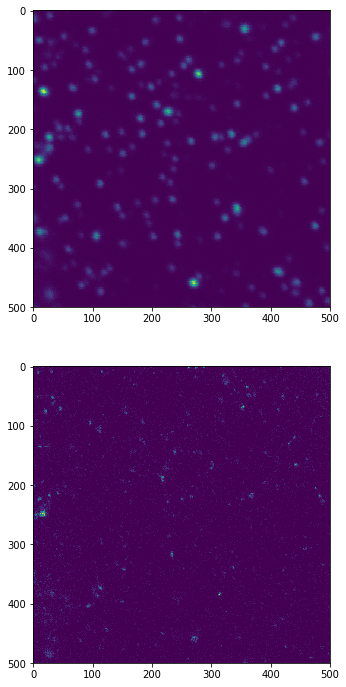

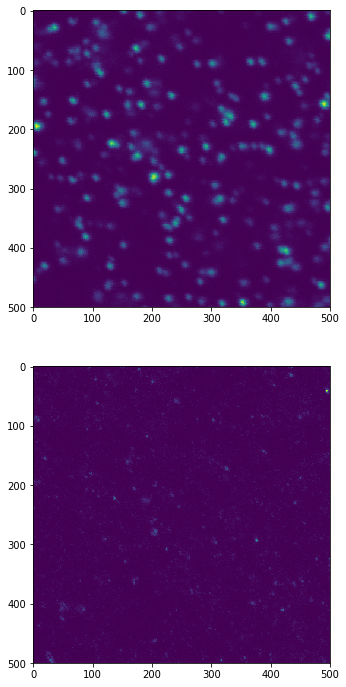

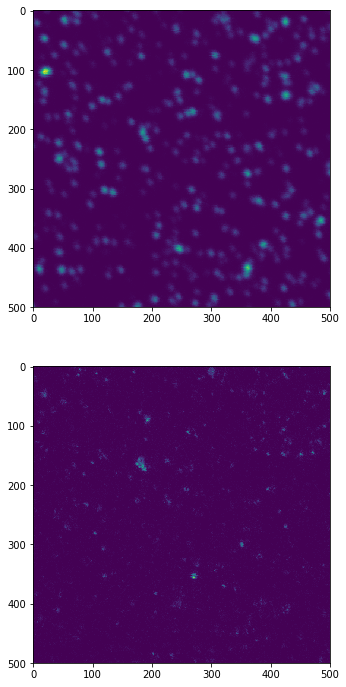

In [2]:
#This is the code for correcting the two colour STED with confocal gfp signal (4 image channels).
#First it corrects the code by 

folderlist =[]
#This is where you add all the folders that your want to search through on your computer"""
folderlist.append('/Users/dwaithe/Documents/collaborators/CarravillaPablo/');

corr_x = 1 ;#The STED to confocal pixel correction in the x-dimension.
corr_y = -2;#The STED to confocal pixel correction in the y-dimension.
diameter_of_roi = 20; #Diameter of the ROI.
noi_tol = 10 #Noise tolerance for the maxima detection.

#output for corrected and registered images
output_path = '/Users/dwaithe/Documents/collaborators/CarravillaPablo/out/'

data_store ={}

for path in folderlist:
    
    
    filelist = [ f for f in listdir(path) if isfile(join(path,f)) ]
            
    for filename in filelist:
        
        if filename[:3] == '.DS':
            continue;
        
        if filename[-4:] != '.msr':
            continue
        
        print 'processing',filename
        im0raw = bioformats.load_image(path+filename, series=0) #confocal 
        im1raw = bioformats.load_image(path+filename, series=1) #sted APD2
        
            
        assert im0raw.shape == im1raw.shape, "Your images are not the same size"
        
        
        data_store[filename] = {}
        
        
        #This is just for comparison. This is the command which corrects confocal to STED detection channels.
        #im0_after, im1_after, im2_after, im3_after = register(im0raw,im1raw,im2raw,im3raw,0,0)
        #Makes the raw figure with just the registration correction.
        #imRGBB,imRGBA = make_figure(im0raw.astype(np.float64),im1raw.astype(np.float64),im2raw.astype(np.float64),im3raw.astype(np.float64))
        
        #Makes the drift corrected. Moves red relative to green. -ve is left and up.
        #The last two numbers define the confocal channel to STED offset. This is supplied by Silvia.
        #im0_after, im1_after,im2_after, im3_after = drift_corr(im0_after,im1_after,im2_after,im3_after,corr_x,corr_y)
        #Makes figure with the registration between red and green channel
        #imRGB2,imRGB1 = make_figure(im0_after,im1_after,im2_after,im3_after)
        
        
        output = np.zeros((2,im0raw.shape[0],im0raw.shape[1])).astype(np.float32)
        output[0,:,:] = im0raw
        output[1,:,:] = im1raw
        output = output*65535
        
        data_store[filename]['img_corr'] = output
        #plotting.
        figsize(12,12)
        figure()
        subplot(2,1,1)
        imshow(im0raw)
        subplot(2,1,2)
        imshow(im1raw)
        
        #savefig('pex/20150415 3 colori Perox/con_output_CorrFull2/fig'+filename, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None)
        metadata = dict(microscope='Abberior', shape=output.shape, dtype=output.dtype.str)
        metadata = json.dumps(metadata)
        tifffile.imsave(output_path+filename.split('.msr')[:-1][0]+'.tiff', output)
        
        
        
        
        img = ndimage.filters.gaussian_filter(output[0,:,:], 2.0)
        ypts, xpts = maxima.find_maxima(noi_tol, img)
        height, width = img.shape
        
        o_xpts, o_ypts, rn_xpts, rn_ypts = return_valid_and_random_pts(xpts, ypts,diameter_of_roi,height, width)
        
        data_store[filename]['height'] = height
        data_store[filename]['width'] = width        
        data_store[filename]['o_xpts'] = o_xpts
        data_store[filename]['o_ypts'] = o_ypts
        data_store[filename]['rn_xpts'] = rn_xpts
        data_store[filename]['rn_ypts'] = rn_ypts

In [3]:
#Saves out the corrected data as a pickle file. So can come back to it.
output_data_path = output_path+'/output_data/'
for file_name in data_store:
    pickle.dump(data_store[file_name], open( output_data_path+file_name[:-4]+".p", "wb" ) )

In [4]:
#Loads in corrected data from a pickle file.
output_data_path = output_path+'/output_data/' #should be same as above.
filelist = [ f for f in listdir(output_data_path) if isfile(join(output_data_path,f)) ]
data_store = {}
for filename in filelist:
    data_store[filename[:-2]+'.msr'] = pickle.load( open(  output_data_path+filename, "rb" ) )
    

170712 1.C S4.msr
170712 3.D S1.msr
170712 1.A S2.msr


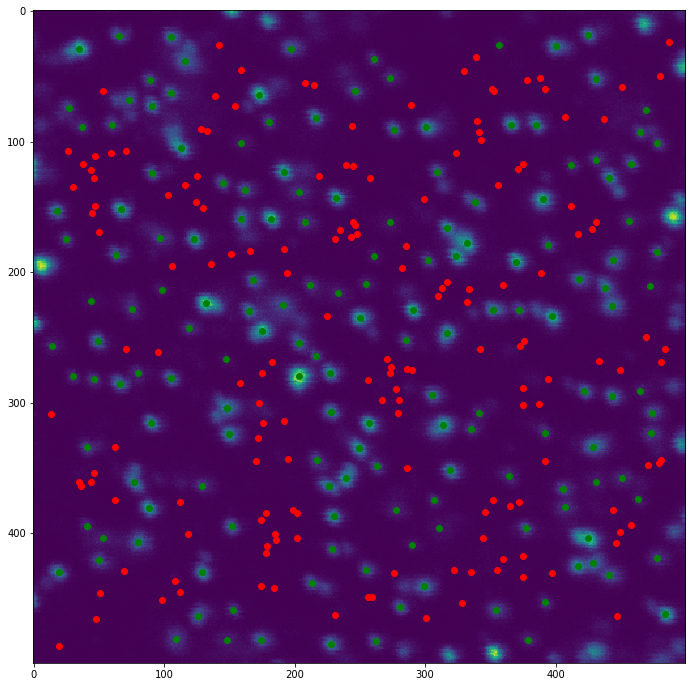

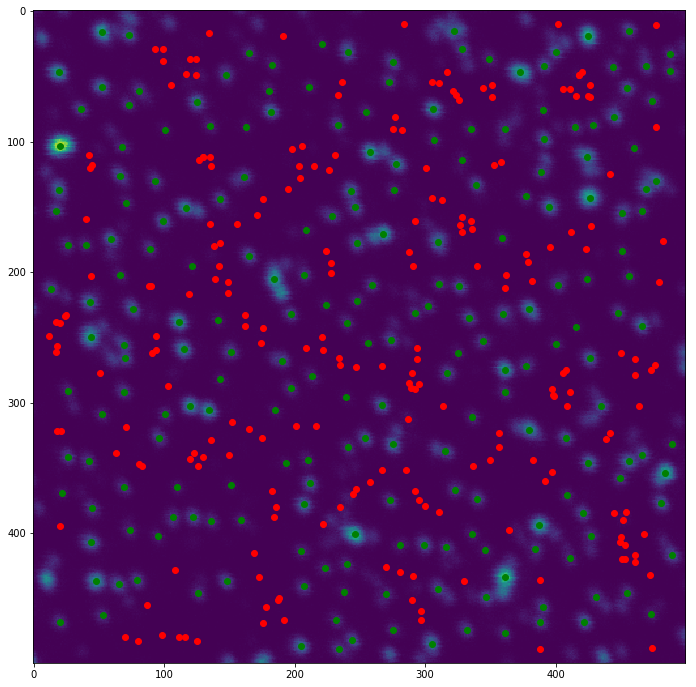

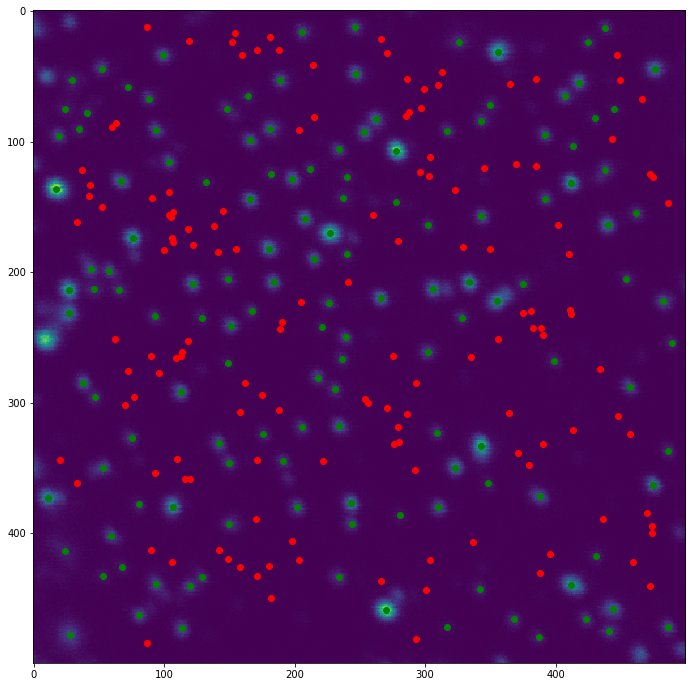

In [5]:
for filename in data_store:
    print filename
    figsize(12,12)
    figure()
    #Plot the peroxisome points (green)
    plot(data_store[filename]['o_xpts'],data_store[filename]['o_ypts'],'go')
    #Plot the random locations (red)
    plot(data_store[filename]['rn_xpts'],data_store[filename]['rn_ypts'],'ro')
    #Overlay points onto the image.
    imshow(data_store[filename]['img_corr'][0,:,:])


In [6]:
import patch_fn as pf
reload(pf)
#Makes measurements for each cell and updates data_store
diameter_of_roi = 20
data_store = pf.calculate_measurements_ch(data_store,diameter_of_roi,False,2) #for regions near perox.
data_store = pf.calculate_measurements_ch(data_store,diameter_of_roi,True,2) #for random regions.
#Current measurements being made/calculated:
#ch0_ave          - mean intensity from regions in channel 0.
#ch1_ave          - mean intensity from regions in channel 1.
#rand_ch0_ave     - mean intensity from random regions in channel 0.
#rand_ch1_ave     - mean intensity from random regions in channel 1.
#ch0_sum          - integrated intensity from regions in channel 0.
#ch1_sum          - integrated intensity from regions in channel 1.
#rand_ch0_sum     - integrated intensity from random regions in channel 0.
#rand_ch1_sum     - integrated intensity from random regions in channel 1.
#ch0_ave_norm     - mean intensity from regions in channel 0 normalised to max for each cell.
#ch1_ave_norm     - mean intensity from regions in channel 1 normalised to max for each cell.
#rand_ch0_ave_norm     - mean intensity from random regions in channel 0 normalised to max for each cell.
#rand_ch1_ave_norm     - mean intensity from random regions in channel 1 normalised to max for each cell.

#ch0_thr_area    - The total area which is above the calculated threshold in the region in channel 0
#ch1_thr_area    - The total area which is above the calculated threshold in the region in channel 1
#ch0_thr_peri    - The total perimater of pixels above threshold in the region in channel 0
#ch1_thr_peri    - The total perimater of pixels above threshold in the region in channel 1
#ch0_thr_circ    - The total circulatory (4*np.pi*(area/perimeter**2))) which is above the calculated threshold in the region in channel 0
#ch1_thr_circ    - The total circulatory (4*np.pi*(area/perimeter**2))) which is above the calculated threshold in the region in channel 1
#chN_thr_num_obj - The total number of independent blobs above threshold within the image.

processing 170712 1.C S4.msr
processing 170712 3.D S1.msr
processing 170712 1.A S2.msr
processing 170712 1.C S4.msr
processing 170712 3.D S1.msr
processing 170712 1.A S2.msr


patch_fn.py:71: RuntimeWarning: divide by zero encountered in long_scalars
  chN_thr_circ.append(4*np.pi*(chN_thr_area[-1]/chN_thr_peri[-1]**2))


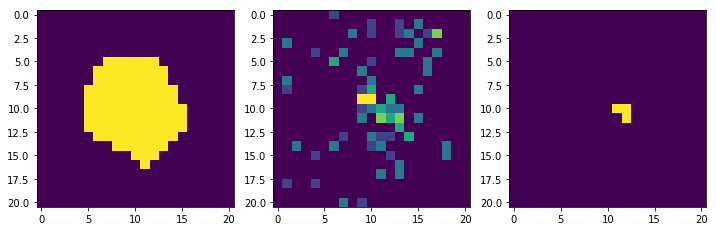

In [132]:
idx = 9#Index of image.
for ds in data_store:
    subplot(1,3,1)
    imshow(data_store[ds]['ch0_erd'][idx]) #first image, ch0 thresholded blobs
    subplot(1,3,2)
    imshow(data_store[ds]['ch1_raw'][idx]) #second image, ch1 raw intensity
    subplot(1,3,3)
    imshow(data_store[ds]['ch1_erd'][idx]) #third image, ch1 thresholded blobs
    #subplot(2,2,4)
    #imshow(data_store[ds]['ch1_erd'][idx])

filename 170712 1.C S4.msr


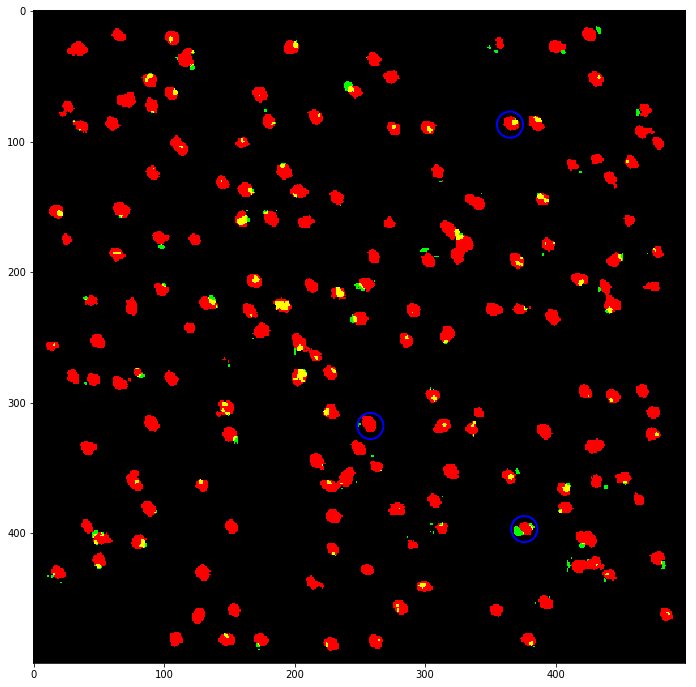

filename 170712 3.D S1.msr


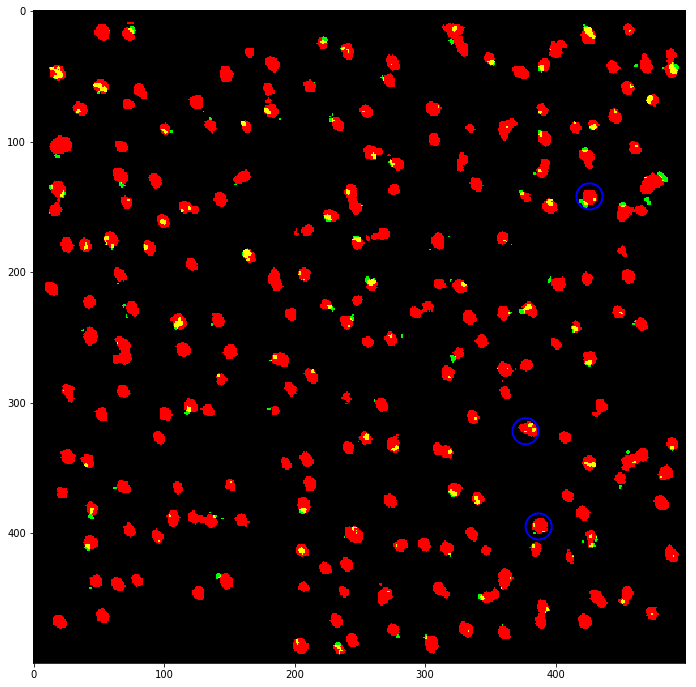

filename 170712 1.A S2.msr


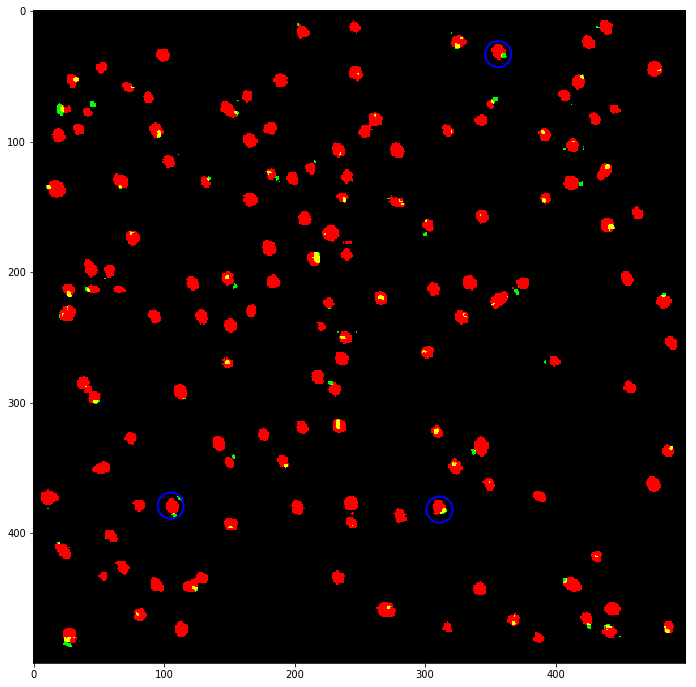

In [135]:

radius = diameter_of_roi//2
rand = False
for filename in data_store:
    outM = np.zeros((height,width,3))
    idx = 0
    if rand == False:
        xpts = data_store[filename]['o_xpts'] 
        ypts = data_store[filename]['o_ypts']
        rand_str = ''
    else:
        xpts = data_store[filename]['rn_xpts'] 
        ypts = data_store[filename]['rn_ypts']
        rand_str = 'rand_'
    for xp, yp in zip(xpts,ypts):
       
        outM[yp-radius:yp+radius+1,xp-radius:xp+radius+1,0] += data_store[filename][rand_str+'ch0_erd'][idx]
        outM[yp-radius:yp+radius+1,xp-radius:xp+radius+1,1] += data_store[filename][rand_str+'ch1_erd'][idx]
        #if data_store[filename][rand_str+'ch1_num_obj'][idx] >= 3:
        idx += 1
    figure()
    print 'filename',filename
    ax = plt.gca()
    ax.imshow(outM)
    if filename == '170712 1.A S2.msr':
        circle=plt.Circle((105,379),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((356,33),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((311,382),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
    if filename == '170712 1.C S4.msr':
        circle=plt.Circle((376,397),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((258,318),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((365,87),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
    if filename == '170712 3.D S1.msr':
        circle=plt.Circle((426,142),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((387,395),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        circle=plt.Circle((377,322),radius, color='b', fill=False, lw=2.0);ax.add_patch(circle);
        
    plt.show()


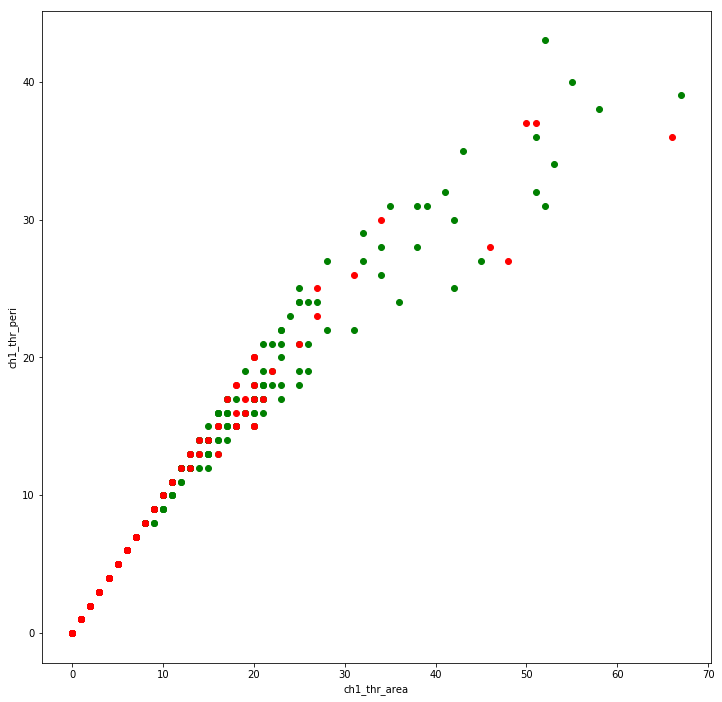

In [63]:

#Example of analysis.
#Comparing Ch1 and Ch3 in the regions close to peroxisome staining
#to Ch1 and Ch3 in regions away from peroxisome staining.

#Collates the measurements for each file and displays them
condition_x = 'ch1_thr_area'
condition_y = 'ch1_thr_peri'

xlabel(condition_x)
ylabel(condition_y)
 
values_x,values_y = collate_data(data_store,condition_x,condition_y)
plot(values_x,values_y,'go')

#Collates the measurements for each file and displays them
condition_x = 'rand_ch1_thr_area'
condition_y = 'rand_ch1_thr_peri'
 
values_x,values_y = collate_data(data_store,condition_x,condition_y)
plot(values_x,values_y,'ro')


In [165]:
tifffile.imsave( 'save.tiff',data_store[ds]['ch3_raw'][14])

In [32]:
ds

'170712 3.D S1.msr'

In [26]:
for d in data_store:
    for c in data_store[d]:
        print c
    break;

rand_ch1_erd
ch1_thr_circ
rand_ch1_thr
img_corr
rand_ch1_thr_circ
ch1_sum
height
rand_ch0_sum
ch0_thr_area
rand_ch0_thr_peri
o_xpts
o_ypts
rand_ch0_thr
rand_ch1_ave
rand_ch1_thr_area
ch0_ave
width
ch0_thr_circ
ch0_raw
rand_ch0_ave
rand_ch1_sum
ch1_erd
ch1_thr_peri
ch0_thr_peri
ch1_thr
rand_ch0_thr_circ
ch0_thr
rand_ch1_raw
ch0_erd
ch1_thr_area
ch0_sum
ch1_ave
rand_ch1_thr_peri
rand_ch0_raw
rn_xpts
rand_ch0_thr_area
rn_ypts
rand_ch0_erd
ch1_raw


In [150]:
from PIL import Image
import numpy as np
%pylab inline
import patch_fn as pf
reload(pf)
img = np.array(Image.open('pex/RGB_im/lena-std.png'))
print pf.renyientropy(img)

Populating the interactive namespace from numpy and matplotlib
125.681357384
